## Primary Imports

In [0]:
# Primary imports
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd 
from pprint import pprint
import seaborn as sns


# For data split 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Import Classifier SVC
from sklearn.svm import SVC
from sklearn import svm

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

#Grid Search
from sklearn.model_selection import GridSearchCV

# Random grid search
from sklearn.model_selection import RandomizedSearchCV

# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler


# Feature Selection
from sklearn.decomposition import PCA

# Cross validation
from sklearn.model_selection import cross_val_score
from statistics import mean

# Data undersampling
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Imports for Learning curve
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Google colab import file
from google.colab import files

# Validation curve
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_digits
from sklearn.linear_model import Ridge

# **SVC model using all CNN and GIST features**

## **Loading training & test data**

In [0]:
# Loading and reading the training data
training_data = pd.read_csv("training.csv")
# Loading and reading the testing data
testing_data  = pd.read_csv("testing.csv")
# Loading and reading the additional training data
additional_data = pd.read_csv("additional_training.csv")
# Loading the annotation confidence data
annotation_data = pd.read_csv("annotation_confidence.csv")

## **Preprocessing - Setting up the data**

In [0]:
# Setting up the data
df_train = training_data.values

# Removing the titles and last column of the training data and assigning to X
X = df_train[:, 1:-1]

# Assigning y to the last column of the training data
y = df_train[:, -1:]
y = y.ravel()

# Replacing the "NaN" values with the mean value of each column
additional_data = additional_data.fillna(additional_data.mean())
df_additional_data = additional_data.values
ad = df_additional_data[:,1:-1]

# Assigning ad_y to the last column of the additional training data
ad_y = df_additional_data[:, -1:]
ad_y = ad_y.ravel()

# Testing values to generate the predictions
df_test = testing_data.values
testdata = df_test[:,1:]

# Pre-processing the data to insert in fit
df_annotation_confidence = annotation_data.values
ac = df_annotation_confidence[:, -1:]

In [0]:
# Concatenate the training data and additional training data (NaN values contain the mean)
# Concatenate the train X and additional train X
X = np.concatenate((X,ad))
# Concatenate the train y and additional train y
y = np.concatenate((y,ad_y))

## **Preprocessing**

### **Normalization - most optimal**
run this cell

In [0]:
# Applying standard normalization to get optimized results
transformer = Normalizer().fit(X)
# Normalizing the X data
X = transformer.transform(X)
# Normalizing the test data
testdata = transformer.transform(testdata)

### Binarization

In [0]:
# Applying binarization as an alternative preprocessing method
# Binarize the X values
X = preprocessing.Binarizer(threshold=0.6).transform(X)
testdata = preprocessing.Binarizer(threshold=0.6).transform(testdata)

### Min-Max

In [0]:
# Applying MinMax scaling the data whilst preserving the shape of the original distribution. 
# It doesn’t meaningfully change the information embedded in the original data.
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
testdata = scaler.transform(testdata)

## **Standardization**

In [0]:
# Applying standardization as a means of pre-processing.
scaler = StandardScaler()
X = scaler.fit_transform(X)
testdata = scaler.fit_transform(testdata)

## **Data undersampling - most optimal**
run this cell

In [229]:
# Applying data undersampling to balance the train and test value split
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
confidence_labels = []

for index in rus.sample_indices_:
  confidence_labels.extend(ac[index])
confidence_values = np.asarray(confidence_labels, dtype = np.float32)

Resampled dataset shape Counter({0.0: 1035, 1.0: 1035})


## **Manual data undersampling** 

In [0]:
count1 = 0
count2 = 0
ac_list = [] 
feature_list = []
label_list = []
for i,feature in enumerate(X):
  if count1 < 1035 and y[i] == 1:
    count1 = count1 + 1
    ac_list.extend(ac[i])
    label_list.append(y[i])
    feature_list.append(feature)
  if count2 < 1035 and y[i] == 0:
    count2 = count2 + 1
    ac_list.extend(ac[i])
    label_list.append(y[i])
    feature_list.append(feature)
  if count1 + count2 == 2070:
    break

X = np.array(feature_list)
y = label_list
sample_weight = ac_list
print(len(X))
print(len(y))
print(len(sample_weight))

2070
2070
2070


## **Feature Selection - PCA - most optimal**
run this cell

In [0]:
# Applying principal component analysis (PCA) to reduce the dimensionality of the training data set consisting of
# a variation of values.
pca = PCA(n_components=0.86, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X_res)
X_res = pca.transform(X_res)
testdata = pca.transform(testdata)

# Grid search investigation 

## **Feature Selection - PCA (Grid Search)**

In [0]:
# Applying principal component analysis (PCA) to reduce the dimensionality of the training data set consisting of
# a variation of values. Running additional grid search to find the optimal n_components value for PCA.
pca_grid = PCA()
param_grid = {'n_components' : np.linspace(0.1,0.9)}
grid_search_pca = GridSearchCV(pca_grid,param_grid, cv = 5, n_jobs = -1, verbose = 10)
grid_search_pca.fit(X_res,y_res.ravel())

In [0]:
print(grid_search_pca.best_params_)

{'n_components': 0.9}


## **Examining the SVC to determine parameters**

In [0]:
# Examining the SVC default parameters for the different grid search methods
svc = SVC(C = 1, kernel = 'rbf',random_state = 42)

# Displaying the default parameters
print('Parameters currently in use:\n')
pprint(svc.get_params())

Parameters currently in use:

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


## **Random Search with Cross Validation**

In [0]:
# Running a Random grid search to optimize the hyperparameters
# C values
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# Gamma values
gamma = [0.001, 0.01, 0.1, 1, 5, 10, 100]
# Kernel values
kernel = ['rbf','linear']
# Creating the random grid
random_grid = {'C': C,'gamma': gammas,'kernel': kernel}
pprint(random_grid)

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'gamma': [0.001, 0.01, 0.1, 1, 5, 10, 100],
 'kernel': ['rbf', 'linear']}


In [0]:
# Using the random grid to search for best hyperparameters
# Creating the base model to tune the model
svc = SVC(random_state = 42)
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and using all available cores
svc_random = RandomizedSearchCV(estimator=svc, param_distributions=random_grid,n_iter = 100, scoring='accuracy',cv = 5, verbose=10, random_state=42, n_jobs=-1,return_train_score=True)
# Fit the random search model
svc_random.fit(X_res, y_res);

Fitting 5 folds for each of 98 candidates, totalling 490 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 98 is smaller than n_iter=100. Running 98 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  81

In [0]:
# Returning the best parameters
svc_random.best_params_

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}

## **SVC Classifier - Grid Search**
We can now perform grid search building on the result from the random search. We will test a range of hyperparameters around the best values returned by random search

In [0]:
# Creating the parameter grid based on the results of random search 
param_grid = {'C': [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2],'gamma': [0.001, 0.0012,0.0013,0.0014,0.0015,0.0016],'kernel': ['linear']}
# Creating a base model
svc = SVC(random_state = 42)
# Instantiate the grid search model
grid_search_svc = GridSearchCV(estimator = svm.SVC(), param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 10,return_train_score=True)

In [0]:
# Fit the grid search to the data
grid_search_svc.fit(X_res, y_res)

In [0]:
# Returning the most optimial grid search
grid_search_svc.best_params_

## **Additional grid search for maximal optmization**

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {'C': [1.5,1.51,1.52,1.53,1.54,1.55,1.56,1.57,1.58,1.59,1.6],'gamma': [0.001,0.0011,0.00112,0.001123,0.0011234,0.00112345,0.00112345],'kernel': ['linear']}
# Creating a base model
svc = SVC(random_state = 42)
# Instantiating the grid search model
grid_search_svc_final = GridSearchCV(estimator = svm.SVC(), param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 10,return_train_score=True)
grid_search_svc_final.fit(X_res, y_res);

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4

In [0]:
# Returning the most optimal parameters
grid_search_svc_final.best_params_

{'C': 1.5, 'gamma': 0.001, 'kernel': 'linear'}

# **SVC Classifier - final model implementation**
The final model with the hyperparameters returned above.

In [231]:
# Implementing the final SVC model with the optimal parameters
# The values from the confidence values are passed into the sample weights
#final_model = grid_search_svc.best_estimator_
svc = SVC(C=1.5, kernel='linear', gamma=0.001)
svc.fit(X_res,y_res,sample_weight = confidence_values)

SVC(C=1.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
y_pred = svc.predict(testdata)

## Cross Validation

In [234]:
# Returning the cross validation score using KFolds. 
scores = cross_val_score(svc, X_res, y_res,cv=15, n_jobs=-1, verbose=10)
print(mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.7s


0.7115942028985507


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   20.1s finished


## **Submission creation for Kaggle competition**

In [238]:
# Creating a nump list of integers from 1 - 2819 to add as header
ID = np.arange(1,2819)
print(ID)

[   1    2    3 ... 2816 2817 2818]


In [236]:
# Creating the pandas dataframe containing the ID values and the Prediction values
# for Kaggle submission
final = [int(x) for x in y_pred]
dataset = pd.DataFrame({'ID':ID,'prediction':final})
dataset

,ID,prediction
0,1,1
1,2,0
2,3,1
3,4,0
4,5,0
5,6,1
6,7,0
7,8,1
8,9,1
9,10,0


In [0]:
# e.g. save pandas output as csv
dataset.to_csv('SVM.csv', index = False)

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('SVM.csv')

## **Learning curve method**

In [0]:
# Plotting learning curve of the trained SVC classifier
# Method found: 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

## **Plotting the learning curve**

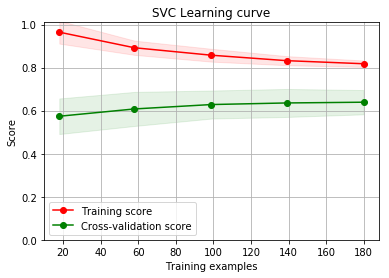

In [128]:
# Plotting the learning curve of the classifier trained
title = "SVC Learning curve"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

plot_learning_curve(svc, title, X_res, y_res, ylim=(0, 1.01), cv=cv, n_jobs=-1)
plt.savefig("learningcurve.png")
files.download("learningcurve.png")
plt.show()

#**SVC Model with only CNN features**
This was an investigation of training a support vector classifier with only the CNN features. The CNN features have a high dimensionality and are very descriptive in terms of image features. These next 19 cells are an implementation of a half split classifier model only using the CNN features. The GIST feature could also be used in the same manner. 

## **Data preparation**

In [0]:
# List of CNN features
cnnFeatures = []
# Seperating each feature
for feature in X:
  cnnFeatures.append(feature[:4096])
X = cnnFeatures
# Splitting the test data
testdata = testdata[:,:4096]

## **Pre-processing - Normalization**

In [0]:
# Applying standard normalization to get optimized results
transformer = Normalizer().fit(X)
# Normalizing the X data
X = transformer.transform(X)
# Normalizing the test data
testdata = transformer.transform(testdata)

## **Undersampling the data**

In [0]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

## **Feature selection - PCA**

In [0]:
# Applying principal component analysis (PCA) to reduce the dimensionality of the training data set consisting of
# a variation of values.

pca = PCA(n_components=0.92, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X_res)
X_res = pca.transform(X_res)
testdata = pca.transform(testdata)

## **SVC classifier**

In [0]:
# Fitting Kernel SVM to the Training set
svc = SVC(C=1.0, kernel='linear', gamma=0.1) 
svc.fit(X_res, y_res) 

In [0]:
# Predicting the Test set results
y_pred = svc.predict(testdata)

## **Cross validation score**

In [0]:
# Returning the cross validation score using KFolds. 
scores = cross_val_score(svc, X_res, y_res.ravel(),cv=5, n_jobs=-1, verbose=10)
print(mean(scores))

## **Preparing data for submission**

In [0]:
# Creating a nump list of integers from 1 - 2819
ID = np.arange(1,2819)
print(ID)

In [0]:
# Creating the pandas dataframe containing the ID values and the Prediction values
# for Kaggle submission
final = [int(x) for x in y_pred]
dataset = pd.DataFrame({'ID':ID,'prediction':final})
dataset

In [0]:
# e.g. save pandas output as csv
dataset.to_csv('SVMcnnundersampled.csv', index = False)

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('SVMcnnundersampled.csv')

## **Plotting the learning curve**

In [0]:
# Plotting the learning curve of the classifier trained
title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=40, test_size=0.2, random_state=0)
plt.savefig("learningcurve.png")
files.download("learningcurve.png")
plot_learning_curve(svc, title, X_res, y_res, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()